In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from multiprocessing import cpu_count
import yaml

import h5py
import numpy as np
import numexpr
import pandas as pd
from scipy import stats
from sklearn.preprocessing import minmax_scale
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from scripts.general import analysis, data, plotting

numexpr.set_num_threads(cpu_count())

8

Using values (for all sequences) saved in `seq_orderings.h5`

```python
python scripts/get_embedded_ordering.py --config results/20211223_182228/experiment_config.yaml \
  --fasta data/seq/scerevisiae_aminoacid_uniprot_20200120_seqlen_100_to_1000.fasta \
  --output results/20211223_182228/seq_orderings.h5
```

In [2]:
with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

seq_data = data.load_seq_and_abundance_data(config)[['swissprot_ac', 'seq']]
n_seq = seq_data.shape[0]

projection_values = {}
centroids_of_projections = {}
with h5py.File('seq_orderings.h5', 'r') as store:
    for prot_id in store.keys():
        embedded_ordering = np.array(store[prot_id], dtype=np.float32)
        projection_values[prot_id] = embedded_ordering
        centroids_of_projections[prot_id] = embedded_ordering.mean()

In [3]:
model_eval = analysis.ModelEvaluator(config)

predictions = {}
for prot_id, seq in tqdm(seq_data[['swissprot_ac', 'seq']].values, total=n_seq, desc='sequences'):
    predictions[prot_id] = model_eval.predict(seq, inverse_boxcox=False)

[2022-04-19 17:57:08] [PID 22449] INFO:	modeling_utils.py:from_pretrained():166:	loading configuration file bert/learn_abundance_transformer_parallel_22-01-14-10-36-57_027418/config.json
[2022-04-19 17:57:08] [PID 22449] INFO:	modeling_utils.py:from_pretrained():183:	Model config {
  "attention_probs_dropout_prob": 0.0,
  "batch_size": 32,
  "finetuning_task": null,
  "gradient_accumulation_steps": 16,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "learning_rate": 2.5681310045153124e-07,
  "max_position_embeddings": 1024,
  "num_attention_heads": 4,
  "num_hidden_layers": 8,
  "num_labels": -1,
  "num_train_epochs": 500,
  "output_attentions": true,
  "output_hidden_states": false,
  "patience": 50,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30
}

[2022-04-19 17:57:08] [PID 22449] INFO:	modeling_utils.py:from_pretrained():514:	loading weights file b

In [4]:
seq_ordering = pd.merge(
    pd.DataFrame.from_records(list(centroids_of_projections.items()), columns=['sissprot_ac', 'projected_centroid']),
    pd.DataFrame.from_records(list(predictions.items()), columns=['sissprot_ac', 'prediction']),
)

In [5]:
centrioids_of_proj_corr_s = stats.spearmanr(seq_ordering['projected_centroid'], seq_ordering['prediction'])
centrioids_of_proj_corr_s

SpearmanrResult(correlation=0.8040598096382391, pvalue=0.0)

Text(0, 0.5, 'Prediction')

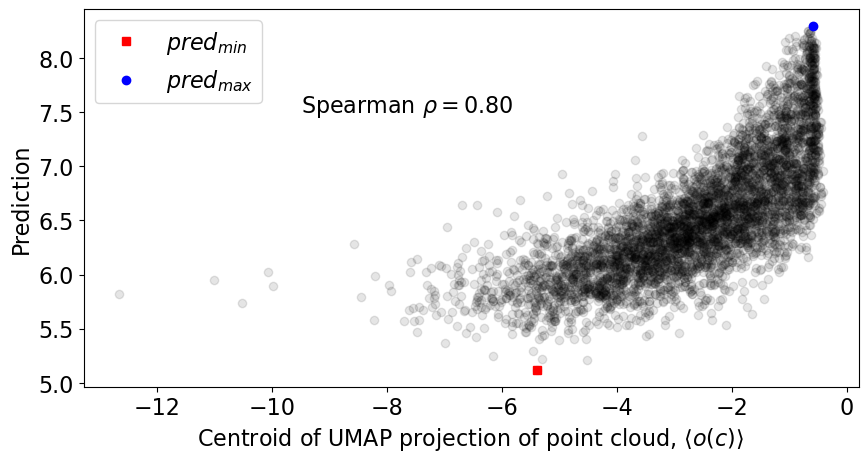

In [6]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 16

order_pred_min = seq_ordering['projected_centroid'].values[np.argmin(seq_ordering['prediction'].values)]
order_pred_max = seq_ordering['projected_centroid'].values[np.argmax(seq_ordering['prediction'].values)]

plt.scatter(seq_ordering['projected_centroid'], seq_ordering['prediction'], color = 'k', alpha=0.1)
plt.plot(order_pred_min, seq_ordering['prediction'].min(), 'sr', label=r'$pred_{min}$')
plt.plot(order_pred_max, seq_ordering['prediction'].max(), 'ob', label=r'$pred_{max}$')
plt.annotate(r"Spearman $\rho = $" + f'{centrioids_of_proj_corr_s[0]:.2f}', (-9.5, 7.5))

plt.legend()
plt.xlabel(r'Centroid of UMAP projection of point cloud, $\langle o(c) \rangle$')
plt.ylabel('Prediction')

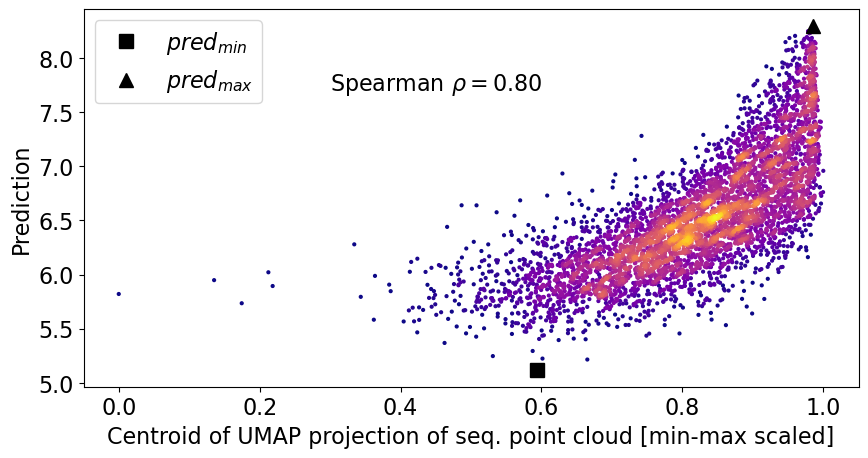

In [7]:
plt.figure(dpi=100, figsize =(10, 5))
plt.rcParams['font.size'] = 16

projected_centroid_norm = minmax_scale(seq_ordering['projected_centroid'])


order_pred_min = projected_centroid_norm[np.argmin(seq_ordering['prediction'].values)]
order_pred_max = projected_centroid_norm[np.argmax(seq_ordering['prediction'].values)]

plotting.scatter_density(
    x = projected_centroid_norm,
    y = seq_ordering['prediction'],    
)


plt.plot(order_pred_min, seq_ordering['prediction'].min(), 'sk', markersize=10, label=r'$pred_{min}$')
plt.plot(order_pred_max, seq_ordering['prediction'].max(), '^k', markersize=10, label=r'$pred_{max}$')


plt.annotate(r"Spearman $\rho = $" + f'{centrioids_of_proj_corr_s[0]:.2f}', (0.3, 7.7))

plt.legend()
plt.xlabel(r'Centroid of UMAP projection of seq. point cloud [min-max scaled]')
_ = plt.ylabel('Prediction')

plt.savefig('corr_ordering_abundance.pdf')

In [8]:
pd.DataFrame.from_records(
    zip(projected_centroid_norm, seq_ordering['prediction']),
    columns = ['centroid_of_projection', 'prediction']
).to_csv('corr_ordering_abundance.csv')

In [9]:
all_projection_values = list(map(lambda a: a.tolist(), projection_values.values()))
all_projection_values = np.concatenate(all_projection_values)

<AxesSubplot:ylabel='Count'>

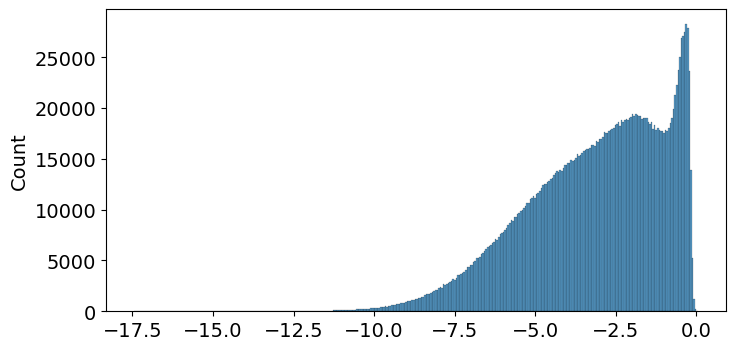

In [10]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = 14

sns.histplot(all_projection_values)

In [11]:
majority_range = (np.percentile(all_projection_values, q = 1), np.percentile(all_projection_values, q = 99))
majority_range

(-8.807732582092285, -0.19892838597297668)

In [12]:
len_majority_range = abs(abs(majority_range[0]) - abs(majority_range[1]))
len_majority_range

8.608804196119308